## Model Training
The modeling phase of the machine learning workflow consists in defining the models to be trained, train the created models, and subsequently test each model's accuracy.

I am using Amazon Sagemaker for the training, testing, and deployment of the defined models. 

In [24]:
import os
from os.path import isfile, join
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow
import statistics
import keras
from statistics import mean, mode, median, stdev
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Activation
from IPython.display import clear_output
from create_model import create_model

In [2]:
from IPython.display import Audio, display

def allDone():
  display(Audio(url='https://www.pacdv.com/sounds/fart-sounds/fart-2.wav', autoplay=True))

In [3]:
# Constants to use for this notebook


# The time ranges that the trained models will predict
time_range = [1, 5, 10, 20, 90, 270]
time_words = {1:'day', 5:'week', 10:'two_weeks', 20:'month', 90:'four_months', 270:'year'}

# The time ranges used for feature calculations
periods = [5, 10, 20, 90, 270]

# directory containing training and testing datasets
data_dir = join('data_2/') 
final_data_dir = join(data_dir + 'final/')
model_directory = 'models_3/'
model_history_directory = model_directory + 'history/'

    

In [4]:
# Read training and testing data
data = {}
for t in time_range:
    for n1 in periods:
        for n2 in periods:
            mod = f'{t}-{n1}-{n2}'
            data[mod] = {}
            train_file = final_data_dir+time_words[t]+f'/{n1}_{n2}/train.csv'
            test_file = final_data_dir+time_words[t]+f'/{n1}_{n2}/test.csv'

            df_train = pd.read_csv(train_file, header=None)
            df_test = pd.read_csv(test_file, header=None)

            y_train = df_train[0]
            X_train = df_train.drop(labels=0, axis=1)
            y_test = df_test[0]
            X_test = df_test.drop(labels=0, axis=1)

            data[mod]['y_train'] = y_train
            data[mod]['X_train'] = X_train
            data[mod]['y_test'] = y_test
            data[mod]['X_test'] = X_test
    

### Model Definition
Under the ``source/`` directory is the file ``model.py``, which contains the definition for a class named ``BinaryClassifier``. This class defines our base ANN model for this project which hast the following structure:
1. Three parameters need to be passed to the model:
    * ``input_features``: the number of neurons to create for input (11 in this case)
    * ``output_dim``: the number of neurons in the final layer of the ANN. For a binary classifier this is 1, and the result ranges from [0,1].
2. The number of neurons in the 4 hidden layers of the model are defined as:
    * ``2*input_features``
    * ``input_features/2``
3. The forward pass of the model
    * Input layer -> Linear transform to the first hidden layer
    * Passed into Rectifier Linear Unit function
    * Dropout layer (for training only)
    * Repeat the above steps until the final hidden layer...
    * Last hidden layer -> Linear transform to the output layer
    * Sigmoid Activation Function -> Result
    

In [5]:
# Define this model's hidden layer nodes and parameters
input_dim = 11
d1 = 2*input_dim
d2 = round(input_dim/2)
d3 = 1
activation = 'sigmoid'
dropout = 0.4
epochs = 10000
lr = 0.01
batch = 100

## Plotting live callback definition

In [6]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend(['accuracy', f'epoch: {epoch}'])
        plt.show();
        
plot = PlotLearning()

In [7]:
models = []
for t in time_range:
    for n1 in periods:
        for n2 in periods:
            model = create_model(t, n1, n2)
            model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
            models.append(model)
    
print(models[0].summary())

Model: "1-5-5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 11)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 22)                264       
_________________________________________________________________
dropout_1 (Dropout)          (None, 22)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 138       
_________________________________________________________________
dropout_2 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
_________________________________________________________________
sigmoid (Activation)         (None, 1)                 0     

### Model Training
The model training will be performed by Amazon Sagemaker. Training jobs will be created for each training dataset in the ``final/`` directory. Under ``source/`` there is a file named ``train.py``, which contains the structure for a PyTorch entry point. This is necesssary for creating estimators through Sagemaker.

In [8]:
if not os.path.exists(model_history_directory):
    os.makedirs(model_history_directory)

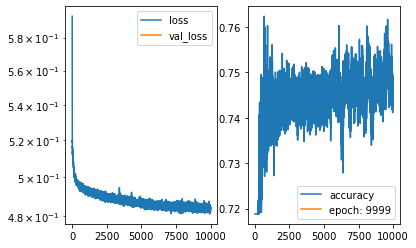

In [9]:
for model in models:
    name = model.name
    if os.path.isfile(model_directory+name+'.h5'):
        print(f'Model {name} has been trained.')
    else:
        X_train = data[name]['X_train']
        y_train = data[name]['y_train']
        
        history = model.fit(x=X_train, 
                  y=y_train,
                  batch_size=batch,
                  epochs=epochs,
                  verbose=0,
                  callbacks=[plot]
                 )


        model.save(model_directory+name+'.h5')
        df = pd.DataFrame.from_dict(history.history)
        df.to_csv(model_history_directory+name+'_history.csv')
        allDone()

### Model Evaluation
For evaluation I am deploying each training job created. For each estimator, a predictor endpoint is created briefly to be sent data to make predictions. For each predictor, their respective test datasets are passed. The endpoint for the predictor is then deleted. Then, accuracy calculations are made against the labeled test datasets, they are printed and stored into ``.txt`` files under the ``results/`` directory.


In [18]:
models = []
for t in time_range:
    for n1 in periods:
        for n2 in periods:
            name = f'{t}-{n1}-{n2}'
            filepath = model_directory+name+'.h5'
            model = create_model(t, n1, n2)
            model.load_weights(filepath)
            models.append(model)

In [20]:
# Read training and testing data separated by tickers
data = {}
for t in time_range:
    for n1 in periods:
        for n2 in periods:
            mod = f'{t}-{n1}-{n2}'
            data[mod] = {}
            data[mod]['train'] = {}
            data[mod]['test'] = {}
            m = mod.split('-')
            directory_tr = final_data_dir+time_words[int(m[0])]+'/'+m[1]+'_'+m[2]+'/train/'
            directory_ts = final_data_dir+time_words[int(m[0])]+'/'+m[1]+'_'+m[2]+'/test/'

            for filename in os.listdir(directory_tr):
                df = pd.read_csv(directory_tr+filename, header=None).iloc[::-1]
                data[mod]['train'][filename.split('.')[0]+'_y'] = df[0]
                data[mod]['train'][filename.split('.')[0]+'_X'] = df.drop(labels=0, axis=1)
            for filename in os.listdir(directory_ts):
                df = pd.read_csv(directory_ts+filename, header=None).iloc[::-1]
                data[mod]['test'][filename.split('.')[0]+'_y'] = df[0]
                data[mod]['test'][filename.split('.')[0]+'_X'] = df.drop(labels=0, axis=1)


    
    

In [ ]:
tickers_file = 'ndxt_tickers.txt'
ndxt_tickers = []
with open('data/'+tickers_file) as f:
    for ticker in f:
        ndxt_tickers.append(ticker.replace('\n', ''))

In [ ]:
evaluation = {}
for model in models:
    evaluation[model.name] = {}
    
    for symbol in ndxt_tickers:
        evaluation[model.name][symbol] = []
        length = len(data[model.name]['test'][symbol+'_X'])
        data_X = data[model.name]['test'][symbol+'_X']
        data_y = data[model.name]['test'][symbol+'_y']
        
        for i in range(length):
            x = data_X[i:i+1]
            y = data_y[i:i+1]
            evaluation[model.name][symbol].append(model.evaluate(x, y, verbose=0)[1])

In [ ]:
acc_streaks = {}
for mod, evals in evaluation.items():
    acc_streaks[mod] = {}
    acc_streaks[mod]['accuracy'] = []
    acc_streaks[mod]['streak'] = []
    
    print(f'Evalutation for model: {mod}\n')
    plt.figure()
    for symbol, accuracies in evals.items():
        print(mod+' '+symbol)
        acc = round(sum(accuracies)/len(accuracies),2)
        print(f'Average accuracy: {acc}')
        
        streak = 0
        for i, a in enumerate(accuracies):
            if a != 1: 
                streak = i
                break
        print(f'Longest accurate streak: {streak}')
        
        acc_streaks[mod]['accuracy'].append(acc)
        acc_streaks[mod]['streak'].append(streak)
        
        plt.subplot()
        plt.hist(range(len(accuracies)), int(len(accuracies)/10), weights=accuracies)
        plt.xlabel('Test samples')
        plt.ylabel('Accuracy')
        plt.title(mod+' tested on '+symbol)
        plt.show()
        
        

In [ ]:
for mod, acc_streak in acc_streaks.items():
    print(f'Model: {mod}')
    acc = sum(acc_streak['accuracy'])/len(acc_streak['accuracy'])
    print(f'Average accuracy: {round(acc, 2)}')
    streak = sum(acc_streak['streak'])/len(acc_streak['streak'])
    print(f'Average longest accurate streak: {round(streak, 2)}')
    print()